In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import cv2
import scipy.misc
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
from random_eraser import get_random_eraser

Augmented data

In [ ]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [13]:
base_path = "C:/Users/saidh/Downloads/archive/real_vs_fake/real-vs-fake/"


batch_size=64

image_gen1 =  ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

train_flow= image_gen1.flow_from_directory(
    base_path + 'train/',
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode ='binary'
)

valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode = 'binary'
)
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size = (224, 224),
    batch_size = 1,
    shuffle = False,
    class_mode ='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers import BatchNormalization
# """
#     Propsoed CNN architecture.
    
# """

# model = Sequential()

# # Pamameters Initialization
# input_shape = (224,224,3)
# activation = 'relu'
# padding = 'same'
# droprate = 0.1
# epsilon = 0.001

# model = Sequential()
# model.add(BatchNormalization(input_shape=input_shape))
# model.add(Conv2D(filters=16, kernel_size=3, activation=activation, padding=padding))
# model.add(MaxPooling2D(pool_size=2))
# model.add(BatchNormalization(epsilon=epsilon))


# model.add(Conv2D(filters=32, kernel_size=3, activation=activation, padding=padding))
# model.add(MaxPooling2D(pool_size=2))
# model.add(BatchNormalization(epsilon=epsilon))
# model.add(Dropout(droprate))

# model.add(Conv2D(filters=64, kernel_size=3, activation=activation, padding=padding))
# model.add(MaxPooling2D(pool_size=2))
# model.add(BatchNormalization(epsilon=epsilon))
# model.add(Dropout(droprate))

# model.add(Conv2D(filters =128, kernel_size=3, activation=activation, padding=padding))
# model.add(MaxPooling2D(pool_size=2))
# model.add(BatchNormalization(epsilon=epsilon))
# model.add(Dropout(droprate))

# model.add(Conv2D(filters=256, kernel_size=3, activation=activation, padding=padding))
# model.add(MaxPooling2D(pool_size=2))
# model.add(BatchNormalization(epsilon=epsilon))
# model.add(Dropout(droprate))

# model.add(Conv2D(filters=512, kernel_size=3, activation=activation, padding=padding))
# model.add(MaxPooling2D(pool_size=2))
# model.add(BatchNormalization(epsilon=epsilon))
# #model.add(Dropout(droprate))

# model.add(GlobalAveragePooling2D())
# #model.add(Flatten())
# #model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu'))
# #model.add(Dropout(0.5))
          
# #model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
# #model.add(Dropout(0.5))
# #model.add(Dropout(droprate))
# model.add(Dense(1, activation='sigmoid'))

# model.summary() # Summary of the architecture

In [15]:
input_shape = (224,224,3)
epsilon=0.001
activation = 'relu'
padding = 'same'
droprate = 0.1


model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=1024, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 56, 56, 32)       

In [16]:
import tensorflow

In [17]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='binary_crossentropy',optimizer= opt, metrics=['accuracy'])

In [18]:
from keras.callbacks import ModelCheckpoint
filepath = "saved-final-model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [20]:
train_steps = 100000//100
valid_steps = 20000//100

history = model.fit_generator(
    train_flow,
    epochs =15,
    callbacks= callbacks_list,
    steps_per_epoch = train_steps,
    validation_data = valid_flow,
    validation_steps = valid_steps
)

Epoch 1/15
1000/1000 [==============================] - 682s 682ms/step - loss: 0.5898 - accuracy: 0.6953 - val_loss: 0.9260 - val_accuracy: 0.5870

Epoch 00001: val_accuracy improved from -inf to 0.58695, saving model to saved-final-model.h5
Epoch 2/15
1000/1000 [==============================] - 690s 690ms/step - loss: 0.5393 - accuracy: 0.7332 - val_loss: 0.6174 - val_accuracy: 0.6903

Epoch 00002: val_accuracy improved from 0.58695 to 0.69031, saving model to saved-final-model.h5
Epoch 3/15
1000/1000 [==============================] - 687s 687ms/step - loss: 0.4971 - accuracy: 0.7601 - val_loss: 0.7067 - val_accuracy: 0.6669

Epoch 00003: val_accuracy did not improve from 0.69031
Epoch 4/15
1000/1000 [==============================] - 685s 685ms/step - loss: 0.4573 - accuracy: 0.7852 - val_loss: 0.4976 - val_accuracy: 0.7605

Epoch 00004: val_accuracy improved from 0.69031 to 0.76047, saving model to saved-final-model.h5
Epoch 5/15
1000/1000 [==============================] - 687s 

# ---------------------------------------------------------------------------------------------------------------

In [10]:
# Parameters Initialization
from tensorflow.keras.optimizers import SGD,Adam,Adadelta
import keras
#opt = rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='binary_crossentropy',optimizer=Adam(0.0001), metrics=['accuracy'])

In [12]:
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# import os

In [13]:
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = 'cifar10_resnet_model.h5'
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# filepath = os.path.join(save_dir, model_name)

In [14]:
# checkpoint = ModelCheckpoint(filepath=filepath,
#                              verbose=1,
#                              save_best_only=True)
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)
# callbacks = [checkpoint, lr_reducer]

In [16]:
# data_augmentation = True
# random_erasing = True
# pixel_level = False

In [27]:
# if not data_augmentation:
#     print('Not using data augmentation.')
#     model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               validation_data=(x_test, y_test),
#               shuffle=True,
#               callbacks=callbacks)
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level))
#     datagen.fit(train_flow)

#     # Fit the model on the batches generated by datagen.flow().
#     model.fit_generator(datagen.flow(train_flow, y_train, batch_size=batch_size),
#                         steps_per_epoch=x_train.shape[0] // batch_size,
#                         validation_data=(x_test, y_test),
#                         epochs=epochs, verbose=1, workers=4,
#                         callbacks=callbacks)

In [11]:
# train_steps = 40000//batch_size
# valid_steps = 5000//batch_size
# history = model.fit_generator(
#     train_flow,
#     epochs=10,
#     steps_per_epoch=train_steps,
#     validation_data=valid_flow,
#     validation_steps=valid_steps
# )

C:\Users\saidh\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
625/625 [==============================] - 2093s 3s/step - loss: 0.7270 - accuracy: 0.6190 - val_loss: 0.6808 - val_accuracy: 0.6266
Epoch 2/10
625/625 [==============================] - 2002s 3s/step - loss: 0.6299 - accuracy: 0.6658 - val_loss: 0.6858 - val_accuracy: 0.6356
Epoch 3/10
625/625 [==============================] - 1998s 3s/step - loss: 0.5940 - accuracy: 0.6918 - val_loss: 0.6417 - val_accuracy: 0.6585
Epoch 4/10
625/625 [==============================] - 1864s 3s/step - loss: 0.5706 - accuracy: 0.7095 - val_loss: 0.5952 - val_accuracy: 0.6977
Epoch 5/10
625/625 [==============================] - 2019s 3s/step - loss: 0.5450 - accuracy: 0.7268 - val_loss: 0.5832 - val_accuracy: 0.7057
Epoch 6/10
625/625 [==============================] - 1971s 3s/step - loss: 0.5154 - accuracy: 0.7454 - val_loss: 0.6104 - val_accuracy: 0.6993
Epoch 7/10
625/625 [==============================] - 1936s 3s/step - loss: 0.5025 - accuracy: 0.7556 - val_loss: 0.5069 - val_accuracy:

In [16]:
model.save("custom_augmented_model1.h5")

In [21]:
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

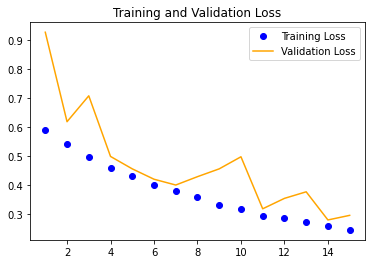

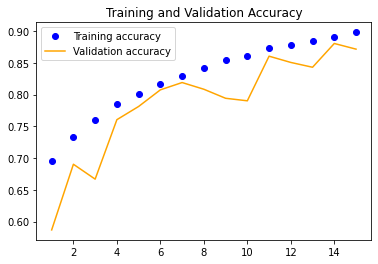

In [23]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

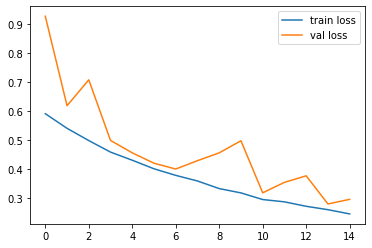

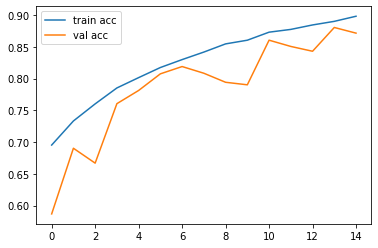

In [24]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [25]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

In [26]:
from sklearn import metrics

In [27]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.9508229950000001
AP Score: 0.9264288141813466

              precision    recall  f1-score   support

           0       0.82      0.94      0.87     10000
           1       0.93      0.79      0.85     10000

    accuracy                           0.86     20000
   macro avg       0.87      0.86      0.86     20000
weighted avg       0.87      0.86      0.86     20000



In [28]:
y_test

array([0, 0, 0, ..., 1, 1, 1])

In [29]:
y_test1 = np.array(y_test)
y_test1

array([0, 0, 0, ..., 1, 1, 1])

In [30]:
y_pred

array([[0.11726575],
       [0.00140755],
       [0.03285345],
       ...,
       [0.6485505 ],
       [0.9793394 ],
       [0.9171788 ]], dtype=float32)

In [31]:
y_pred1 = y_pred.copy()
np.where(y_pred1 > 0.5, 1, 0)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [32]:
y_pred2 = y_pred1.flatten()
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)
y_pred2

array([0, 0, 0, ..., 1, 1, 1])

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred2)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[9373  627]
 [2075 7925]]
acc: 0.8649
sensitivity: 0.9373
specificity: 0.7925


In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred2)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[9373  627]
 [2075 7925]]
acc: 0.8649
sensitivity: 0.9373
specificity: 0.7925


<AxesSubplot:>

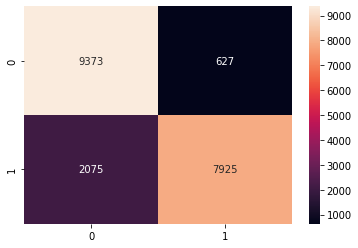

In [35]:
import seaborn as sns
sns.heatmap(cm,annot=True, fmt='g')